In [ ]:
import os

# Copy these exactly from your screenshot
os.environ['KAGGLE_USERNAME'] = "ashnaimtiaz"
os.environ['KAGGLE_KEY'] = "My_kaggle_key"

# Now download the plant disease dataset for free
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

# Unzip the data into your project folder
import zipfile
with zipfile.ZipFile('plantvillage-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/')

print("Data is ready in the 'dataset/' folder!")

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 96% 1.96G/2.04G [00:12<00:02, 41.2MB/s]
100% 2.04G/2.04G [00:12<00:00, 171MB/s] 
Data is ready in the 'dataset/' folder!


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Data Augmentation**

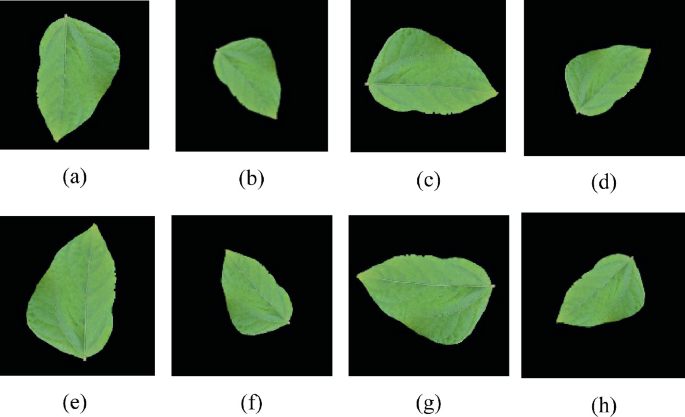

In [ ]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation (Makes your model "Smarter" with less data)
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalization [0,1]
    rotation_range=20,       # Randomly rotate images
    zoom_range=0.2,          # Randomly zoom
    horizontal_flip=True,    # Flip images
    validation_split=0.2     # Use 20% for testing
)

Even with thousands of images, Data Augmentation is vital to prevent overfitting. It teaches the model that a diseased leaf is still diseased even if it is rotated, zoomed, or dimly lit. This ensures "AgriVision XAI" works reliably in real-world farm conditions, not just on perfect dataset photos.

### **Load the DATASET**

In [ ]:
# I add extra folder path created by the Kaggle unzip
data_path = 'dataset/plantvillage dataset/color'

In [ ]:
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 43456 images belonging to 38 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 10849 images belonging to 38 classes.


# **Transfer Learning**

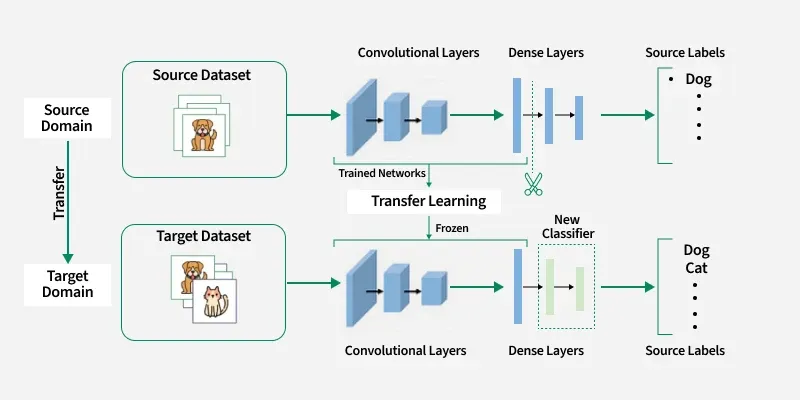

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

## **Load Pre-trained MobileNetV2 (Feature Extractor)**

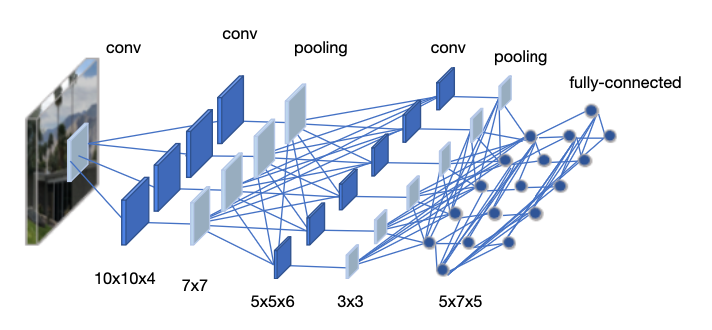

In [ ]:
# include_top=False removes the original 1000-class classifier
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
  )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model (Non-trainable)
base_model.trainable = False

In [ ]:
# Freeze the base model (Non-trainable)
base_model.trainable = False

In [ ]:
# Adding Custom Neural Network (The "Head")
x = base_model.output
x = GlobalAveragePooling2D()(x) # Flattens the map to a single vector
x = Dense(128, activation='relu')(x) # Hidden layer for complexity
x = Dropout(0.2)(x) # Prevents Overfitting


# **Output Layer**

![image.png]()![image.png](
  
)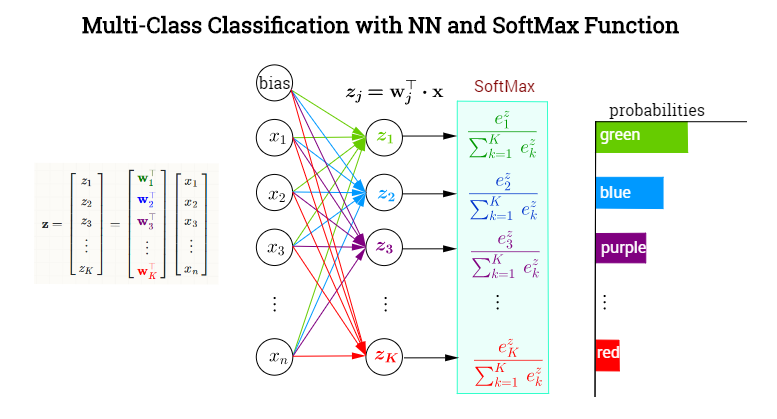

In [ ]:
# 'num_classes' is the number of disease folders found earlier
num_classes = train_generator.num_classes
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
num_classes

38

In [ ]:
# Final Model Construction
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Frozen Base:** We are keeping the "eyes" of the model that already know how to see shapes, edges, and textures.

**Custom Head:** We are adding a new "brain" that learns specifically what a "Potato Blight" spot looks like.

**GlobalAveragePooling:** This reduces the complex 3D data from the base model into a simple 1D format that the final layers can understand.

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 643s 460ms/step - accuracy: 0.7289 - loss: 1.0037 - val_accuracy: 0.9264 - val_loss: 0.2380
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 607s 447ms/step - accuracy: 0.9075 - loss: 0.2858 - val_accuracy: 0.9310 - val_loss: 0.2019
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 606s 446ms/step - accuracy: 0.9191 - loss: 0.2373 - val_accuracy: 0.9311 - val_loss: 0.2008
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 613s 452ms/step - accuracy: 0.9270 - loss: 0.2161 - val_accuracy: 0.9436 - val_loss: 0.1689
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 600s 442ms/step - accuracy: 0.9349 - loss: 0.1961 - val_accuracy: 0.9382 - val_loss: 0.1872
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 605s 446ms/step - accuracy: 0.9405 - loss: 0.1762 - val_accuracy: 0.9424 - val_loss: 0.1669
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 607s 447ms/step - accuracy: 0.9388 - loss: 0.1781 - val_accuracy: 0.9474 - val_loss: 0.1553
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 600s 442ms/step - ac

In [ ]:
model.save('AgriVision_XAI_Model.h5')
print("Model saved as AgriVision_XAI_Model.h5")

Model saved as AgriVision_XAI_Model.h5


In [ ]:
from google.colab import files

# This triggers the browser to download the file you saved earlier
files.download('AgriVision_XAI_Model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


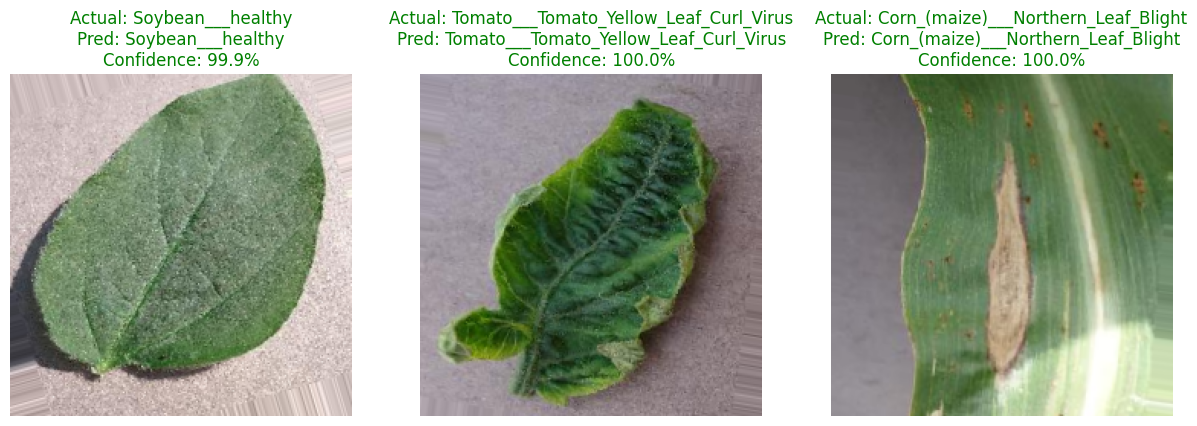

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def test_random_predictions(n_images=3):
    # 1. Grab a batch of images from the validation set
    images, labels = next(validation_generator)

    # 2. Map class indices back to their names (e.g., 0 -> "Potato_Healthy")
    class_indices = train_generator.class_indices
    labels_map = {v: k for k, v in class_indices.items()}

    # 3. Make predictions for the whole batch
    predictions = model.predict(images)

    # 4. Visualize the results
    plt.figure(figsize=(15, 10))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])

        # Get the predicted and actual labels
        actual_idx = np.argmax(labels[i])
        pred_idx = np.argmax(predictions[i])
        confidence = predictions[i][pred_idx] * 100

        title_color = 'green' if actual_idx == pred_idx else 'red'
        plt.title(f"Actual: {labels_map[actual_idx]}\nPred: {labels_map[pred_idx]}\nConfidence: {confidence:.1f}%", color=title_color)
        plt.axis('off')
    plt.show()

# Run it to see 3 random tests
test_random_predictions(3)

# Applying Explainable AI

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. CORE XAI ENGINE: Grad-CAM Heatmap Generation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the predicted class wrt the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by "importance"
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


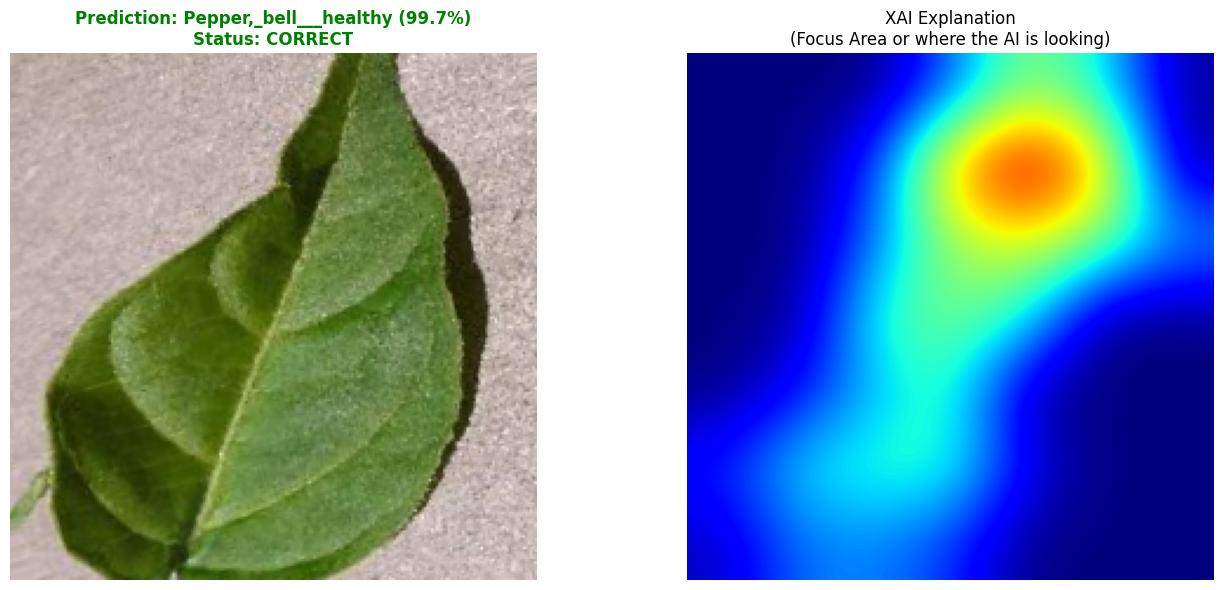

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_agrivision_melted_xai(img_index=0):
    # 1. Pull data
    images, labels = next(validation_generator)
    img_array = images[img_index]
    img_batch = np.expand_dims(img_array, axis=0)

    # 2. Prediction
    preds = model.predict(img_batch)
    class_idx = np.argmax(preds[0])
    actual_idx = np.argmax(labels[img_index])

    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    confidence = preds[0][class_idx] * 100

    # 3. Generate Heatmap
    heatmap = make_gradcam_heatmap(img_batch, model, 'out_relu')

    # 4. Display with "Melted" effect
    plt.figure(figsize=(14, 6))
    title_color = 'green' if class_idx == actual_idx else 'red'
    status = "CORRECT" if class_idx == actual_idx else "WRONG"

    # --- LEFT SIDE: Original ---
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f"Prediction: {class_labels[class_idx]} ({confidence:.1f}%)\nStatus: {status}",
              color=title_color, fontsize=12, fontweight='bold')
    plt.axis('off')

    # --- RIGHT SIDE: Melted Heatmap ---
    plt.subplot(1, 2, 2)
    # 'bicubic' interpolation creates the "melted" liquid effect
    plt.imshow(heatmap, cmap='jet', interpolation='bicubic')
    plt.title("XAI Explanation\n(Focus Area or where the AI is looking)", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the melted visual
run_agrivision_melted_xai(img_index=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ Report saved successfully as: AgriVision_Final_Report.png


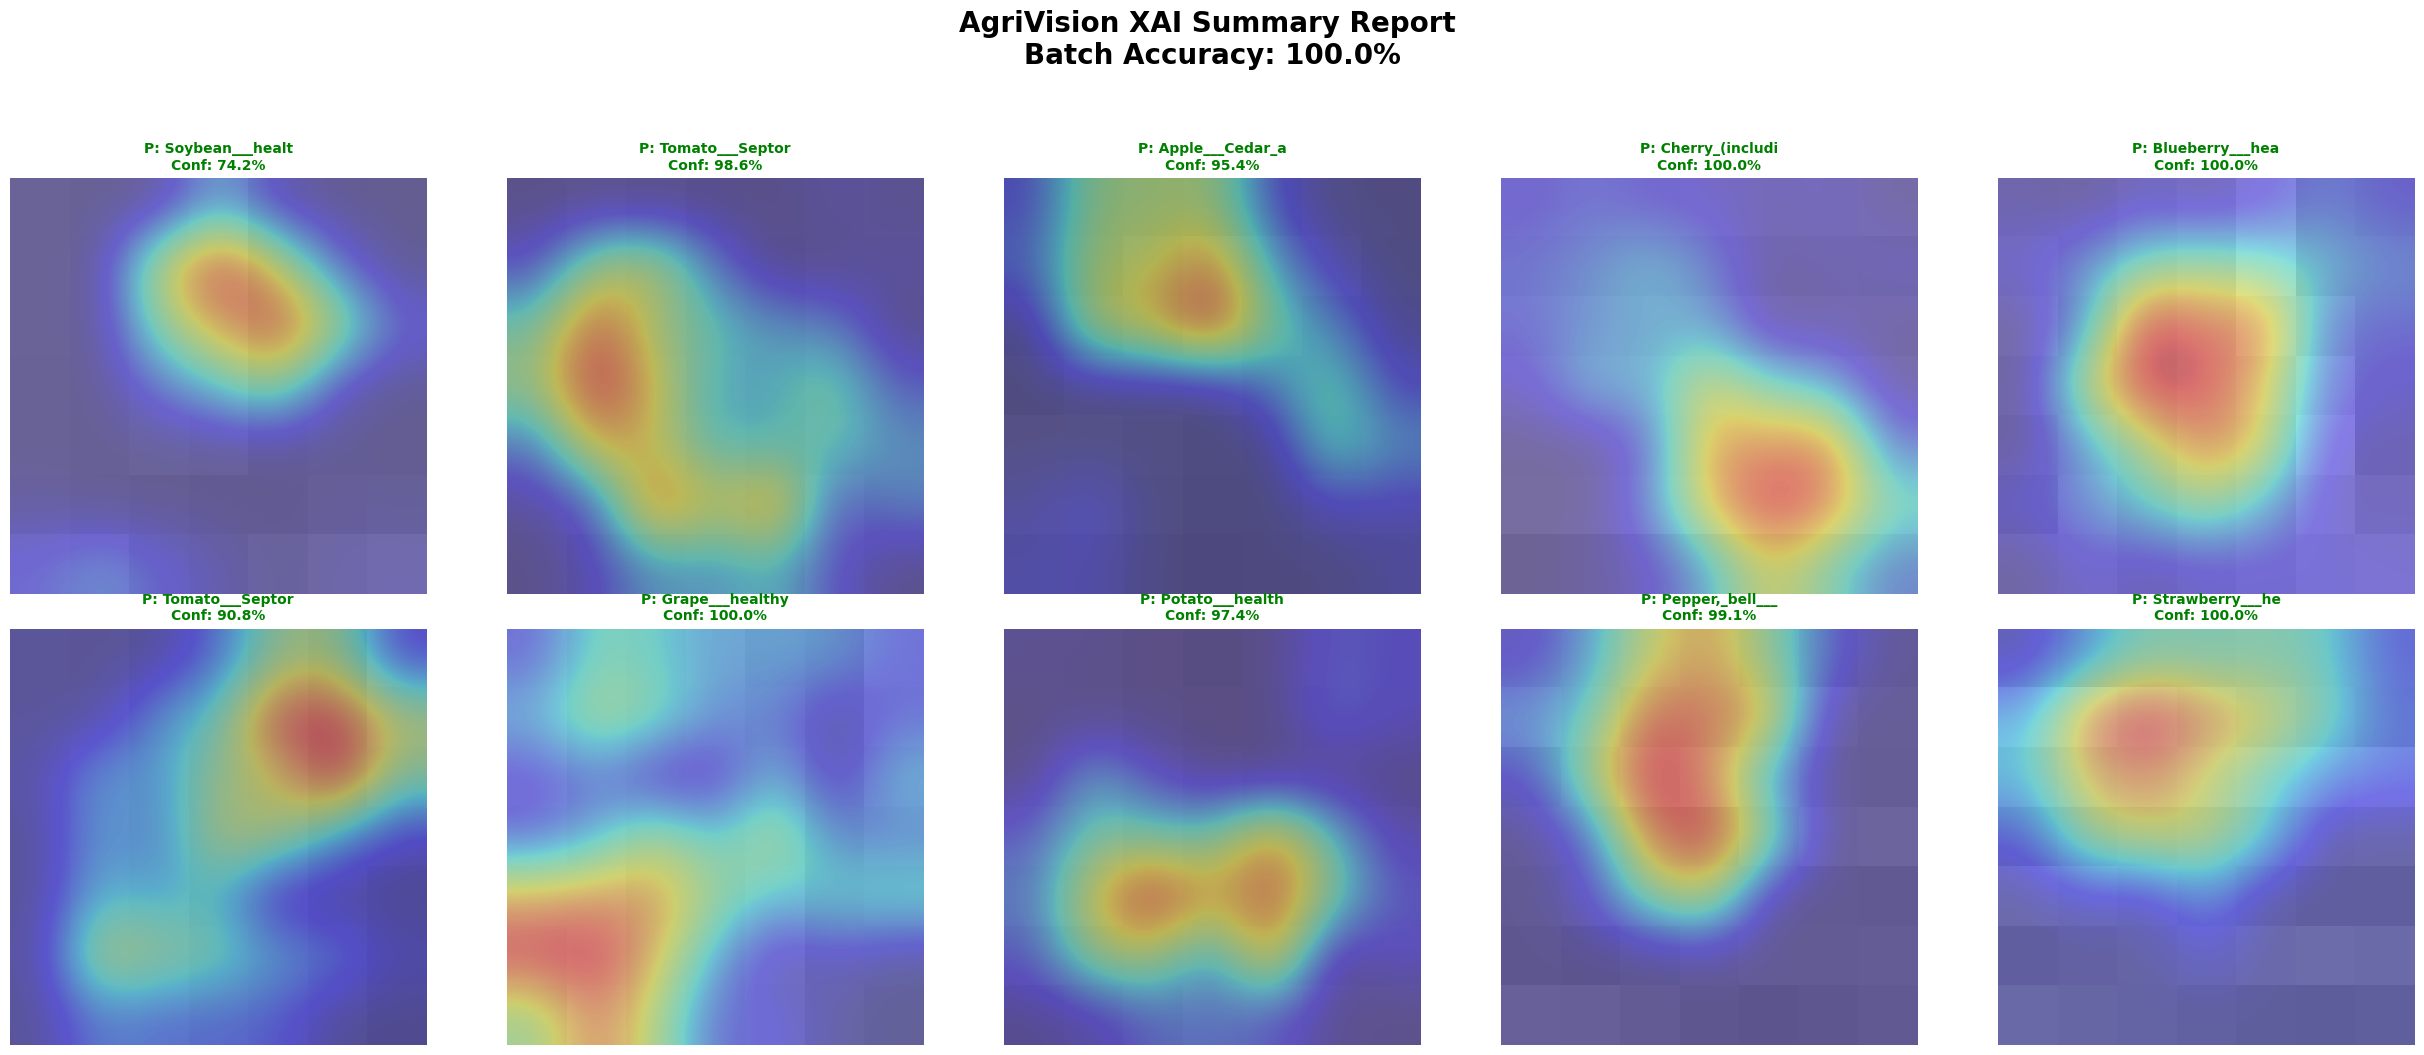

In [ ]:
import os

def generate_and_save_report(num_samples=10):
    images, labels = next(validation_generator)
    class_labels = {v: k for k, v in train_generator.class_indices.items()}

    plt.figure(figsize=(25, 10))
    correct_count = 0

    for i in range(num_samples):
        img_array = images[i]
        img_batch = np.expand_dims(img_array, axis=0)

        preds = model.predict(img_batch)
        class_idx = np.argmax(preds[0])
        actual_idx = np.argmax(labels[i])
        confidence = preds[0][class_idx] * 100

        title_color = 'green' if class_idx == actual_idx else 'red'
        if class_idx == actual_idx: correct_count += 1

        heatmap = make_gradcam_heatmap(img_batch, model, 'out_relu')

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_array)
        # The "Melted" overlay for a professional look
        plt.imshow(heatmap, cmap='jet', alpha=0.4, interpolation='bicubic')

        plt.title(f"P: {class_labels[class_idx][:15]}\nConf: {confidence:.1f}%",
                  color=title_color, fontsize=10, fontweight='bold')
        plt.axis('off')

    report_title = f"AgriVision XAI Summary Report \nBatch Accuracy: {(correct_count/num_samples)*100:.1f}%"
    plt.suptitle(report_title, fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()

    # --- SAVE THE IMAGE ---
    filename = "AgriVision_Final_Report.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"✅ Report saved successfully as: {filename}")

    plt.show()

# Run and save
generate_and_save_report(10)

# Applying Edge Computing

In [ ]:
import tensorflow as tf

# 1. Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Optimize for size (this is the Edge Computing magic)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# 2. Save the lightweight model
with open('agrivision_edge_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Edge model created! Check your files sidebar.")

Saved artifact at '/tmp/tmpsltl7j0d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  137121864496720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864712848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864712272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864497680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864498256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864498064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864713808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864714768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864714384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137121864714000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1371218647124

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import glob

# 1. SETUP: Provide your model path and a folder with test images
model_path = "agrivision_edge_model.tflite"
image_files = glob.glob("*.jpg")[:10]  # Takes the first 10 jpg images you upload

# 2. LOAD TFLITE
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 3. CLASS NAMES (Manually defined since generators aren't running)
# Note: You should update this list to match your actual 38 classes
class_names = ['Apple_scab', 'Apple_black_rot', 'Grape_leaf_blight', 'Tomato_Early_blight'] # Add more

plt.figure(figsize=(20, 10))

for i, img_path in enumerate(image_files):
    # Preprocess image
    img = Image.open(img_path).resize((224, 224))
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_details[0]['index'])

    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx] * 100

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[class_idx]}\nConf: {confidence:.1f}%", color='green', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

# Final Evaluation

Evaluating model against 38 possible categories...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


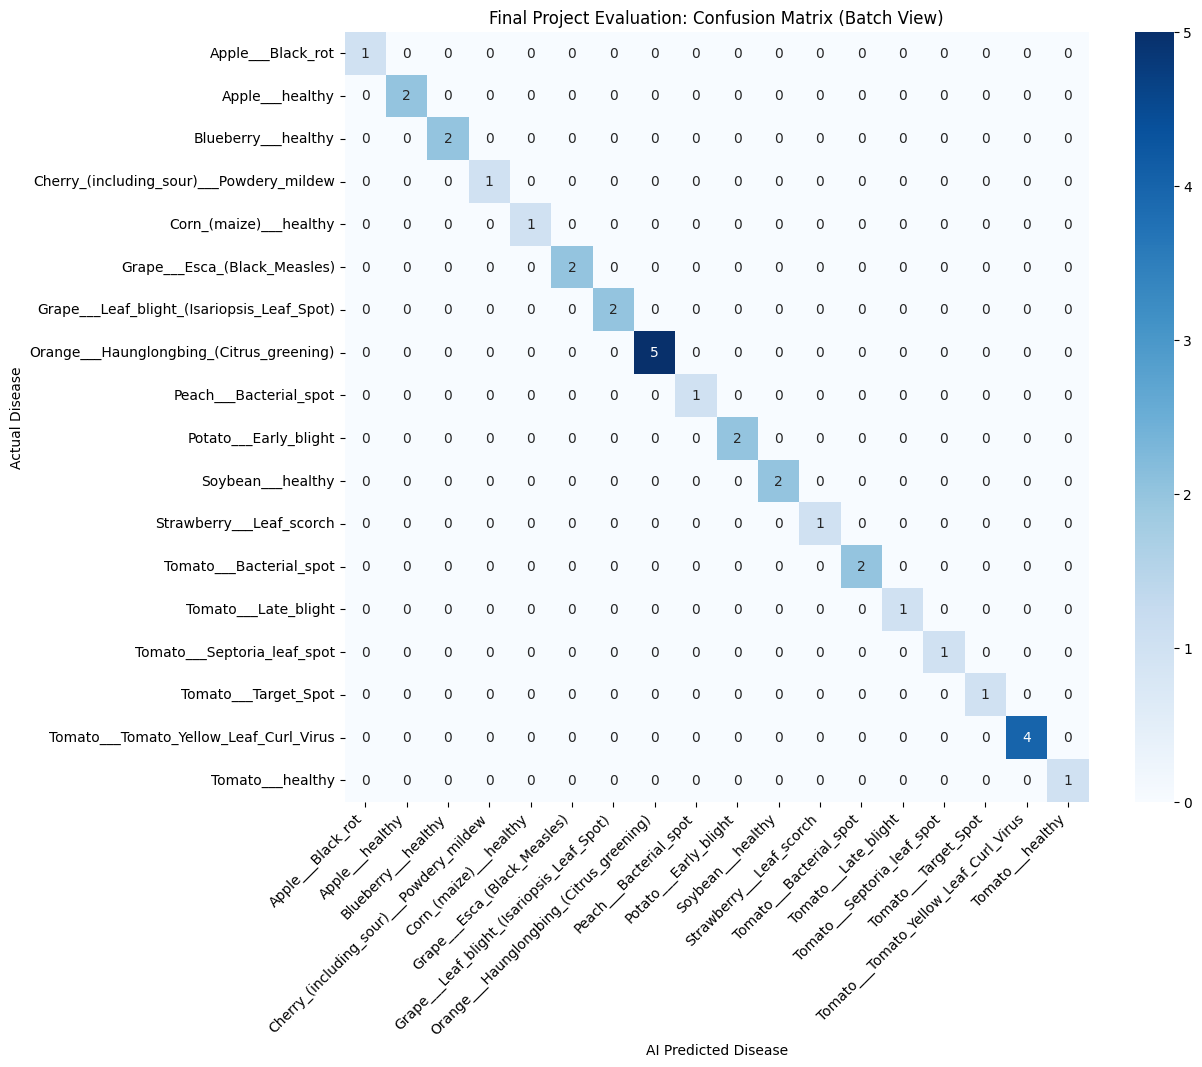


Detailed Classification Report:

                                            precision    recall  f1-score   support

                         Apple___Black_rot       1.00      1.00      1.00         1
                           Apple___healthy       1.00      1.00      1.00         2
                       Blueberry___healthy       1.00      1.00      1.00         2
  Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00         1
                    Corn_(maize)___healthy       1.00      1.00      1.00         1
              Grape___Esca_(Black_Measles)       1.00      1.00      1.00         2
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00         2
  Orange___Haunglongbing_(Citrus_greening)       1.00      1.00      1.00         5
                    Peach___Bacterial_spot       1.00      1.00      1.00         1
                     Potato___Early_blight       1.00      1.00      1.00         2
                         Soybean___health

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def run_final_evaluation():
    # 1. Get the class mapping (The 38 names)
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    all_class_names = [class_labels[i] for i in range(len(class_labels))]

    print(f"Evaluating model against {len(all_class_names)} possible categories...")

    # 2. Grab a larger batch of validation data to ensure more diversity
    # Note: If your validation_generator has shuffle=True, this pulls a random batch
    val_images, val_true_labels = next(validation_generator)

    # 3. Get AI Predictions
    preds = model.predict(val_images)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(val_true_labels, axis=1)

    # 4. Create Confusion Matrix (Filtered to classes actually present in this batch)
    unique_in_batch = np.unique(np.concatenate([true_labels, pred_labels]))
    names_in_batch = [class_labels[i] for i in unique_in_batch]

    cm = confusion_matrix(true_labels, pred_labels)

    # 5. Plotting
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=names_in_batch, yticklabels=names_in_batch)
    plt.title('Final Project Evaluation: Confusion Matrix (Batch View)')
    plt.ylabel('Actual Disease')
    plt.xlabel('AI Predicted Disease')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # 6. Detailed Stats - FIXED: We tell it exactly which labels to expect
    print("\nDetailed Classification Report:\n")
    print(classification_report(true_labels, pred_labels,
                                labels=unique_in_batch,
                                target_names=names_in_batch))

# Run the fixed evaluation
run_final_evaluation()

In [ ]:
from google.colab import drive
from google.colab import files
import os
import shutil

# --- PHASE 1: Try Google Drive (Cloud Backup) ---
try:
    print("Attempting to mount Google Drive...")
    drive.mount('/content/drive', force_remount=True)

    # Define paths
    drive_path = '/content/drive/MyDrive/AgriVision_Backup'
    if not os.path.exists(drive_path):
        os.makedirs(drive_path)

    # Save files to Drive
    model.save(f'{drive_path}/agrivision_final_model.h5')
    shutil.copy('agrivision_edge_model.tflite', f'{drive_path}/agrivision_edge_model.tflite')
    print(f"✅ Cloud Backup Success! Files saved in Drive folder: AgriVision_Backup")

except Exception as e:
    print(f"❌ Drive Mount Failed (Error: {e}). Switching to local backup...")

# --- PHASE 2: Forced Local Download (PC Backup) ---
print("\nTriggering direct downloads to your computer...")

# Save the .h5 locally first to ensure it exists
model.save('agrivision_final_model.h5')

# These lines will pop up 'Save As' boxes in your browser
files.download('agrivision_final_model.h5')
files.download('agrivision_edge_model.tflite')

print("\n🚀 CHECK YOUR BROWSER: You should see two files downloading right now!")
print("Once they finish, you can safely turn off your project.")

Attempting to mount Google Drive...


❌ Drive Mount Failed (Error: Error: credential propagation was unsuccessful). Switching to local backup...

Triggering direct downloads to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🚀 CHECK YOUR BROWSER: You should see two files downloading right now!
Once they finish, you can safely turn off your project.


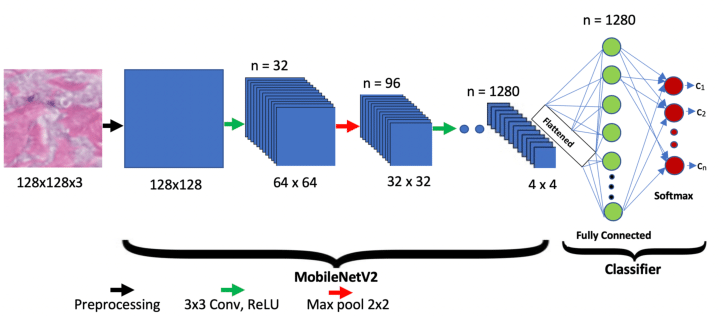